In [1]:
import corv
import pyphot
from pyphot import unit
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pygaia.errors.astrometric import parallax_uncertainty
import lightning as pl

Could not find the pickled WD models. If you need to use these models, please re-import corv with the proper path.
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [2]:
model = corv.models.Spectrum('1d_da_nlte')
library = pyphot.get_library()

def forward(teff, parallax, radius, bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']):
    pc_to_m = 3.0856775814671916e16
    rsun_to_m = 6.957e8
    bands = [library[band] for band in bands]
    wavl, interp = model.wavl, model.model_spec
    
    distance = 100 / parallax
    flux = interp((teff, 8)) * ((radius*rsun_to_m) / (distance * pc_to_m))**2
    band_flux = np.array([band.get_flux(wavl * unit['AA'], flux * unit['erg/s/cm**2/AA'], axis=1).value for band in bands])
    return band_flux

def sim_forward(teff, plx, radius, bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z'], snr = np.random.uniform(300, 400)):
    band_flux = forward(teff, plx, radius, bands)
    band_flux_noisy = np.random.normal(band_flux, band_flux/snr)
    return band_flux, np.concatenate([band_flux_noisy, band_flux_noisy/snr])

In [3]:
bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']
wavl = np.array([library[band].lpivot.to('AA').value for band in bands])

theta = np.array([10000, 12, 0.01])
plx_mu, plx_theta = np.random.uniform(12, 0.3), 0.3
zdata, xdata = sim_forward(*theta, snr = 10)

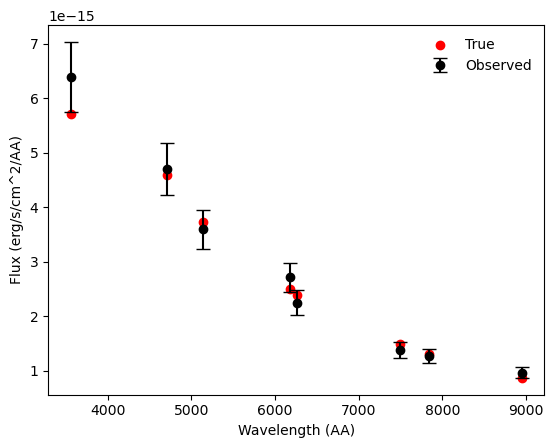

In [4]:
plt.errorbar(wavl, xdata[:len(bands)], yerr = xdata[len(bands):], fmt = 'o', capsize=5, c = 'k', label='Observed')
plt.scatter(wavl, zdata, label='True', c = 'red')
plt.xlabel('Wavelength (AA)')
plt.ylabel('Flux (erg/s/cm^2/AA)')
plt.legend(framealpha=0)

## Approximate Bayes Computation

In [7]:
def log_prior(theta):
    teff, plx, radius = theta
    if (3000 < teff < 20000) and (1 < plx < 50) and (0.01 < radius < 0.1):
        return -0.5 * (np.log(2 * np.pi * plx_theta**2) + ((theta[1] - plx_mu) ** 2 / (plx_theta**2)))
    else:
        return -np.inf

def log_likelihood(theta, xdata, xnoise):
    _, model_flux_noisy = sim_forward(*theta, snr = 10)
    y_model, y_noise = model_flux_noisy[:len(bands)], model_flux_noisy[len(bands):]
    return np.sum(-0.5*np.square(((xdata - y_model) / (np.sqrt(xnoise**2 + y_noise**2)))) - np.log(np.sqrt(2*np.pi) * np.sqrt(xnoise**2 + y_noise**2)))

def log_prob(theta, xdata, xnoise):
    return log_prior(theta) + log_likelihood(theta, xdata, xnoise)  

In [10]:
import emcee
import corner

# Sampling with `emcee`
ndim, nwalkers = 3, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(xdata[:len(bands)], xdata[len(bands):]))

# Initialize the walkers
theta_guess = np.random.uniform(low=(10000, 1, 0.01), high=(20000, 50, 0.1), size=(nwalkers, ndim))
pos = theta_guess + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 4/5000 [00:04<1:30:21,  1.09s/it]

emcee: Exception while calling your likelihood function:
  params: [2.04446220e+04 3.83749334e+01 1.19961231e-01]
  args: (array([2.24952457e-15, 3.59791114e-15, 1.27690876e-15, 6.39236592e-15,
       4.70156610e-15, 2.71228106e-15, 1.38149915e-15, 9.65555489e-16]), array([2.24952457e-16, 3.59791114e-16, 1.27690876e-16, 6.39236592e-16,
       4.70156610e-16, 2.71228106e-16, 1.38149915e-16, 9.65555489e-17]))
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/arsen/miniconda3/envs/stark/lib/python3.12/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_493238/2328573221.py", line 14, in log_prob
    return log_prior(theta) + log_likelihood(theta, xdata, xnoise)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_493238/2328573221.py", line 9, in log_likelihood
    _, model_flux_noisy = sim_forward(*theta, snr = 10)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_493238/3113883888.py", line 16, in sim_forward
    band_flux = forward(teff, plx, radius, bands)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_493238/3113883888.py", line 7, in forward
    bands = [library[band] for band in bands]
             ~~~~~~~^^^^^^
  File "/home/arsen/miniconda3/envs/stark/lib/python3.12/site-pac

KeyboardInterrupt: 